In this notebook, we implement the Unet model on the BraTS MRI training set using the fastai library. The steps taken to implement this model are few compared to those found in brats_processing.ipynb. 
It is important to note that the use of a GPU will be necessary since our data set consists of thousands of images more than 50GB and that the use of the GPU in Colab may not be sufficient. If you find that processing or training is too slow, you may want to use AWS as an alternative. There you can create a notebook instance and specify the number of GPUs and storage space needed at some cost. Use of the GPU in Colab is free. 
Since we are using Colab here, we are taking training data from a google drive directory with the help of a google import further down in the notebook.

NOTE: this particular notebook was implemented in AWS. So you won't see the google drive import and mound. If you need to see the import and code for mounding your notebook to google drive, please see the brats_processing notebook.

Be sure to import the following api. 

In [0]:
'''
train on an AWS p3.2xl instance - MUCH faster.
'''


%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

Store image and label directories in variables. 

In [0]:
path_img = Path('./brats_png/images')
path_lbl = Path('./brats_png/labels')

Use fastai api to invoke get_image_files and collect all our training and label data.

In [0]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

Visualize an image from the training set using fastai open_image()

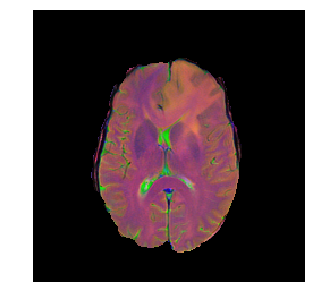

In [0]:
img_f = fnames[5]
img = open_image(img_f)
img.show(figsize=(5,5))

This function takes a path as a parameter and returns a label/mask for the brain slice image above img_f. 

In [0]:
def get_y_fn(path):
    name = path.name
    return path_lbl/('mask_'+name)

Let's visualize one of our labels/masks using fastai -- open_mask

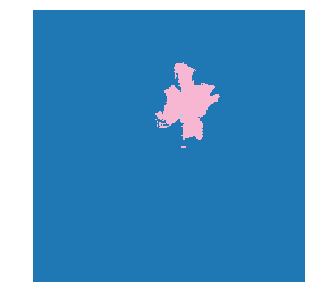

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

We are getting rid of dimension 0. It is the 3rd unecessary dimension. Our masks should only have 2 dimensions. 

In [0]:
#checking and saving shape
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([240, 240]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

Codes for classes in the segmentation mask/ground truth labels. These are the range of pixel values that compose a mask if you display the array of a mask. Fastai requires these codes as a parameter.

In [0]:
codes = np.array(['0','1','2','3','4'], dtype='<U17')#<U17 unicode symbol 
                                                     #for number of bits to store each character
                                                     
#tumor class codes
len(list(codes))

5

We are shrinking the mask size to half size. This technique improves computational efficiency as there are less pixels to learn. 

In [0]:
size = src_size//2

This code checks the system for free GPU RAM in case our GPU cannot handle the batch size while training. We input batch size = 16 into the proper parameter of our Unet model since we our certain our GPU has enough available RAM to handle a batch size of 16 images.

In [0]:
free = gpu_mem_get_free_no_cache()
#max size of bs depends on the available GPU RAM
if free > 8200: bs=16
else:           bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")

using bs=16, have 16118 MB of GPU RAM free


SegmentationItemList is a list object that takes the training image file directory. Fastai allows us to chain methods as below. We are splitting the data with split_by_rand_pct into training and testing data. We use label_from_func to pass our get_y_fn into the labels parameter and codes into the classes parameter. 

In [0]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_rand_pct(.2)
      .label_from_func(get_y_fn, classes=codes))

src.transform is an augmentation method for randomizing the data. It generates images based on the images provided. It flips, rotates, shifts images. It can generate new pixel intensities. We specify our mask size, and transformations on the mask. If we do not perform transformations on our y labels along with our training data then our labels will not map properly and we will get poor predictions. databunch allows us to utilize free RAM and the normalize method takes in a parameter specifying your preferred statistical technique. The choice to use imagenet_stats here is that is it optimized for images.

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

Checking to see if the training date and labels are matched up with each other.

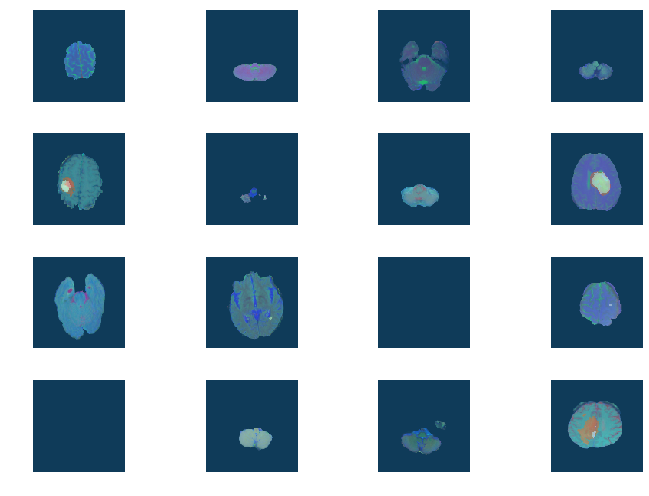

In [0]:
data.show_batch(4, figsize=(10,7))

In [0]:
#dictionary for class codes
name2id = {v:k for k,v in enumerate(codes)}

In [0]:
#class code 0 is the null class, no information
void_code = name2id['0']

NOTE: At this point we have our predicted codes.

This classwise accuracy function will be input as a metric to our model.  We squeeze the target batch dimension so that we have a 2d mask image. We should not have the 3rd dimension. Instead of 1,120,120, we have 120,120 after squeezing. We want the mask to be redefined as non zero class code pixel values. Lastly, we are returning the mean accuracy based on max values along the dimension of depth, rgb. We want the max values of the training image along dimension 1 where mask values are non zero. NOTE: the mask variable is boolean array and you can use it to index into another array just as we did here. 
These are our predicted code values and we compare them with the ground truth label values where the values are non zero. The boolean values get cast to floats(0.0/1.0) and we take the mean. That is our accuracy score for the image. 

In [0]:
def acc_classwise(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_classwise

Weight decay is an optimization parameter. This is a value chosen from fastai website. 

In [0]:
#weight decay
wd = 1e-2

The unet_learner is an object that loads all the parameters: accuracy metric, standard weight distribution, data and model specification. We instantiate this object prior to training on the fit_one_cycle(). 

In [0]:
learn = unet_learner(data, models.resnet50, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.9MB/s]


Learning Rate

In [0]:
lr = 3e-3

This is a final step. fit_one_cycle will do all the learning. It will print out accuracy score, train loss, validation loss, run time for each epoch. 

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_classwise,time
0,0.023437,0.019879,0.457395,12:01


In [0]:
learn.save("brats_fastai_1", return_path=True)

PosixPath('brats_png/images/models/brats_fastai_1.pth')

Once we have our weights from the fitted model, we can call the model to train on a single image using the fastai api. 

In [0]:
msk_true = learn.data.train_ds[321][1]
img = learn.data.train_ds[321][0]

We print an image.

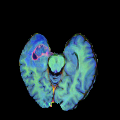

In [0]:
img

We print a mask.

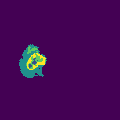

In [0]:
msk_true

We print the prediction mask.

In [0]:
pred = learn.predict(img)[0]

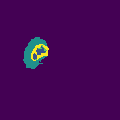

In [0]:
pred